# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на новые тарифы. Нужно построить модель для выбора подходящего тарифа. Модель должна быть с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75.

Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<a id="1.0"></a>
## Открыть и изучить файл

In [1]:
import pandas as pd
pd.options.display.max_rows = 999

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    data = pd.read_csv('users_behavior.csv', sep=',')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


array([[<AxesSubplot:title={'center':'calls'}>,
        <AxesSubplot:title={'center':'minutes'}>],
       [<AxesSubplot:title={'center':'messages'}>,
        <AxesSubplot:title={'center':'mb_used'}>],
       [<AxesSubplot:title={'center':'is_ultra'}>, <AxesSubplot:>]],
      dtype=object)

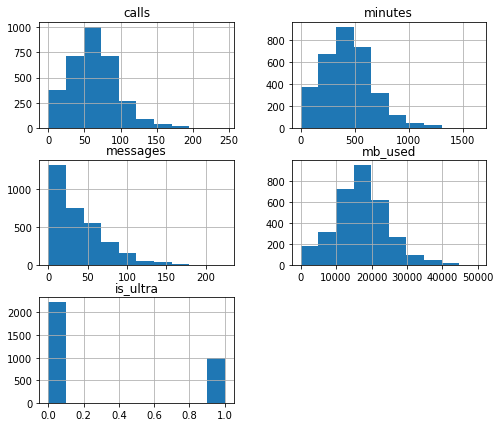

In [6]:
data.hist(figsize=(8,7))

Данные предобработаны, нет пропусков или аномалий, типы оставим float.

<a id="2.0"></a>
## Разбиение данных на выборки

In [7]:
from sklearn.model_selection import train_test_split

features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.2, random_state=54321)

features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=.25, random_state=54321)

Размеры выборок:

In [8]:
print([f.shape[0]/features.shape[0] for f in [features_train, features_valid, features_test]])

[0.5998755444928439, 0.2000622277535781, 0.2000622277535781]


<a id="3.0"></a>
## Исследование модели

### Дерево решений

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

for depth in range(1, 12, 2):
    model = DecisionTreeClassifier(max_depth=depth, random_state=54321)
    model.fit(features_train, target_train)
    accuracy = accuracy_score(target_valid, model.predict(features_valid))
    print('max_depth =', depth,': ', end='')
    print(accuracy)

max_depth = 1 : 0.7231726283048211
max_depth = 3 : 0.7667185069984448
max_depth = 5 : 0.7698289269051322
max_depth = 7 : 0.776049766718507
max_depth = 9 : 0.7558320373250389
max_depth = 11 : 0.7465007776049767


<a id="3.2"></a>
### Случайный лес

In [10]:
from sklearn.ensemble import RandomForestClassifier

best_model = None
best_result = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print(f"Accuracy наилучшей модели на валидационной выборке: {best_result}. Количество деревьев: {best_est}. Максимальная глубина:{best_depth}")

Accuracy наилучшей модели на валидационной выборке: 0.7947122861586314. Количество деревьев: 30. Максимальная глубина:9


<a id="3.3"></a>
### Линейная регрессия

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=54321, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)

result = model.score(features_valid, target_valid)

print("Accuracy модели линейной регрессии на валидационной выборке:", result)

Accuracy модели линейной регрессии на валидационной выборке: 0.6734059097978227


Лучше всех себя показал случайный лес на 30 деревьев, с максимальной глубиной дерева 9.

<a id="4.0"></a>
## Проверка модели на тестовой выборке

In [12]:
test_result = best_model.score(features_test, target_test)

print("Accuracy наилучшей модели случайного леса на тестовой выборке:", test_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

Accuracy наилучшей модели случайного леса на тестовой выборке: 0.8398133748055988 Количество деревьев: 30 Максимальная глубина: 9


Результат на тестовой выборке еще лучше, чем на валидационной.

<a id="5.0"></a>
## Проверка модели на адекватность

In [13]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
prediction_dummy = dummy_model.predict(features_test)

print('Accuracy dummy:', accuracy_score(target_test, prediction_dummy))

Accuracy dummy: 0.7153965785381027


<a id="6.0"></a>
## Вывод

Мы разбили данные на тренировочную, валидационную и тестовую выборки. Построили несколько предсказательных моделей предложения тарифов, в том числе дерево решений, сад, и логистическую регрессию, перебрали параметры глубины и количества деревьев. В результате наибольшая accuracy 0.79 у сада с 30 деревьев и глубиной дерева 9, что неплохо. И адекватнее, чем DummyClassifier.